     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.0 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.0FH7PA_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.JUL3O8_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
Epoch 1/10
10/10 [==============================] - 36s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0086 - factorized_top_k/top_10_categorical_accuracy: 0.0193 - factorized_top_k/top_50_categorical_accuracy: 0.0988 - factorized_top_k/top_100_categorical_accuracy: 0.1788 - loss: 69803.4822 - regularization_loss: 0.0000e+00 - total_loss: 69803.4822
Epoch 2/10
10/10 [==============================] - 29s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0029 - factorized_top_k/top_5_categorical_accuracy: 0.0189 - factorized_top_k/top_10_categorical_accuracy: 0.0383 - factorized_top_k/top_50_categorical_accuracy: 0.1678 - factorized_top_k/top_100_categorical_accuracy: 0.2917 - loss: 67493.9787 - regularization_loss: 0.0000e+00 - total_loss: 67493.9787
Epoch 3/10
10/10 [===========

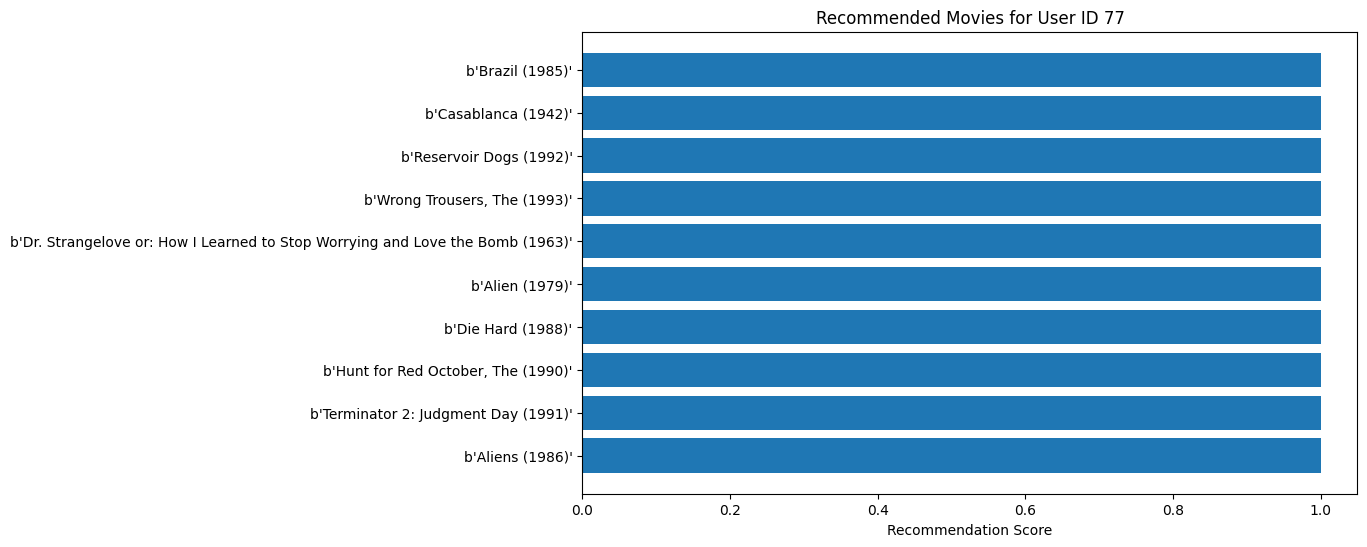

In [ ]:

!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Set up the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model)
    )
)

# Create the model class
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model: tf.keras.Model = user_model
        self.movie_model: tf.keras.Model = movie_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

# Create an instance of the model
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model
model.fit(cached_train, epochs=10)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")

# Function to get movie recommendations for a user
def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True)
    top_indices = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :top_k].numpy()
    recommended_movies = [movie_titles[i] for i in top_indices]
    return recommended_movies

# Example: Get recommendations for a specific user ID
user_id_example = "77"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

# Example of plotting a graph (you can modify this to suit your actual data and requirements)
plt.figure(figsize=(10, 6))
plt.barh(range(len(recommended_movies)), [1] * len(recommended_movies), align='center')
plt.yticks(range(len(recommended_movies)), recommended_movies)
plt.xlabel('Recommendation Score')
plt.title(f'Recommended Movies for User ID {user_id_example}')
plt.gca().invert_yaxis()
plt.show()

In [ ]:

!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

# Set up embeddings
embedding_dimension = 64  # Adjusted embedding dimension

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Set up the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model)
    )
)

# Create the model class
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model: tf.keras.Model = user_model
        self.movie_model: tf.keras.Model = movie_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

# Create an instance of the model
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model
model.fit(cached_train, epochs=10)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")

# Function to get movie recommendations for a user
def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True)
    top_indices = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :top_k].numpy()
    recommended_movies = [movie_titles[i] for i in top_indices]
    return recommended_movies

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

Epoch 1/10
10/10 [==============================] - 38s 3s/step - factorized_top_k/top_1_categorical_accuracy: 8.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0079 - factorized_top_k/top_10_categorical_accuracy: 0.0184 - factorized_top_k/top_50_categorical_accuracy: 0.0990 - factorized_top_k/top_100_categorical_accuracy: 0.1798 - loss: 69636.9290 - regularization_loss: 0.0000e+00 - total_loss: 69636.9290
Epoch 2/10
10/10 [==============================] - 34s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0183 - factorized_top_k/top_10_categorical_accuracy: 0.0372 - factorized_top_k/top_50_categorical_accuracy: 0.1702 - factorized_top_k/top_100_categorical_accuracy: 0.2964 - loss: 67047.3473 - regularization_loss: 0.0000e+00 - total_loss: 67047.3473
Epoch 3/10
10/10 [==============================] - 36s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy:

Epoch 1/10
10/10 [==============================] - 37s 3s/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0071 - factorized_top_k/top_10_categorical_accuracy: 0.0173 - factorized_top_k/top_50_categorical_accuracy: 0.0924 - factorized_top_k/top_100_categorical_accuracy: 0.1712 - loss: 69816.5483 - regularization_loss: 0.0000e+00 - total_loss: 69816.5483
Epoch 2/10
10/10 [==============================] - 31s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0181 - factorized_top_k/top_10_categorical_accuracy: 0.0370 - factorized_top_k/top_50_categorical_accuracy: 0.1631 - factorized_top_k/top_100_categorical_accuracy: 0.2843 - loss: 67531.3182 - regularization_loss: 0.0000e+00 - total_loss: 67531.3182
Epoch 3/10
10/10 [==============================] - 31s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy:

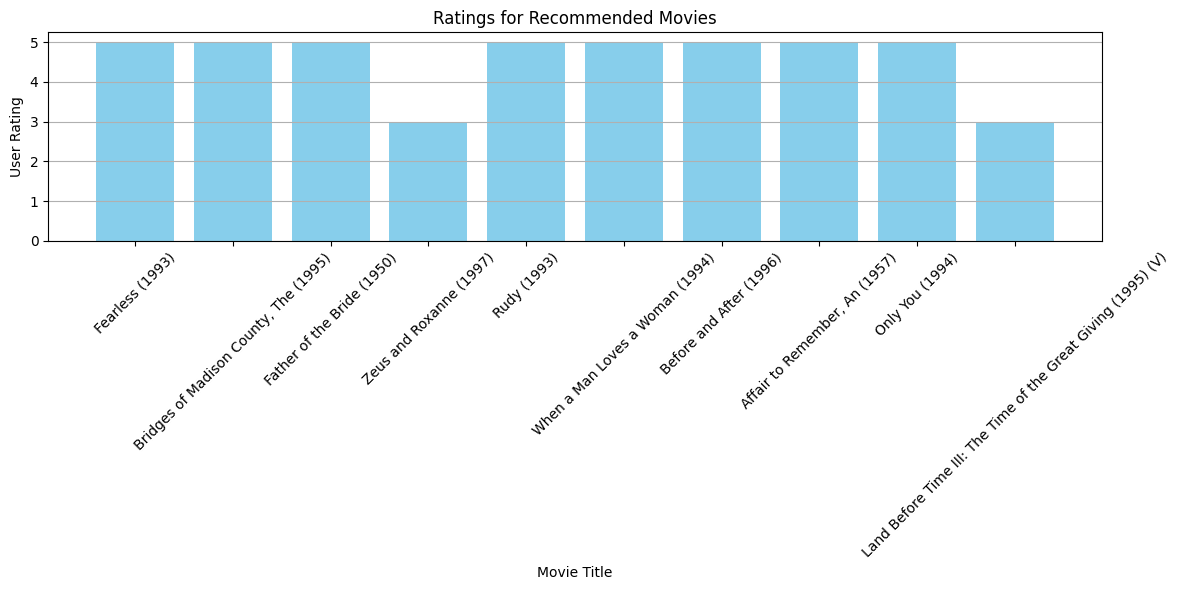

In [ ]:

# Install necessary packages if not already installed
!pip install -q matplotlib pandas tensorflow-datasets

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Set up the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model)
    )
)

# Create the model class
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model: tf.keras.Model = user_model
        self.movie_model: tf.keras.Model = movie_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

# Create an instance of the model
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model
model.fit(cached_train, epochs=10)

# Function to get movie recommendations for a user
def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True)
    top_indices = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :top_k].numpy()
    recommended_movies = [movie_titles[i] for i in top_indices]
    return recommended_movies

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Convert TensorFlow datasets to Pandas DataFrames
movies_df = tfds.as_dataframe(movies)
ratings_df = tfds.as_dataframe(ratings)

# Assuming 'user_rating' is the correct column name for ratings
ratings_df = ratings_df[['movie_title', 'user_rating']]

# Fetch ratings for recommended movies
recommended_movies_ratings = ratings_df[ratings_df['movie_title'].isin(recommended_movies)]

# Plot ratings for recommended movies
plt.figure(figsize=(12, 6))
plt.bar(recommended_movies_ratings['movie_title'], recommended_movies_ratings['user_rating'], color='skyblue')
plt.title('Ratings for Recommended Movies')
plt.xlabel('Movie Title')
plt.ylabel('User Rating')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()